# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False, loss_history=[]):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = loss_history
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(-(X @ weights)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        return np.log(1 + np.exp(-(weights @ x.T) * y)).mean() + (1 / (2 * self.C)) * np.linalg.norm(weights, 2)
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.loss_history = []
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            delta = -(X_ext.T @ (y * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T) * y))))) / len(y) + self.weights_ / self.C
            self.weights_ -= self.eta * delta
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(delta, 2) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [6]:
from sklearn import datasets
from sklearn import metrics

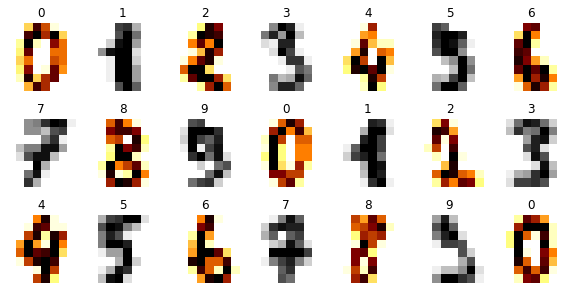

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    print(metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [14]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [15]:
model = CustomLogisticRegression()

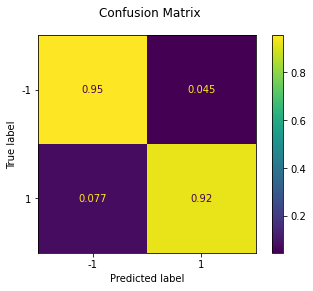

0.9109255393180237 0.9388888888888889


In [16]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [17]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [18]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

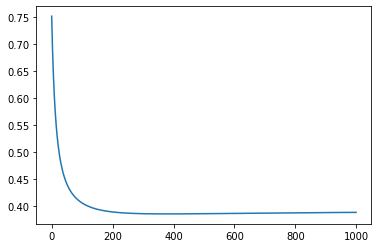

In [19]:
plt.plot(model.loss_history)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

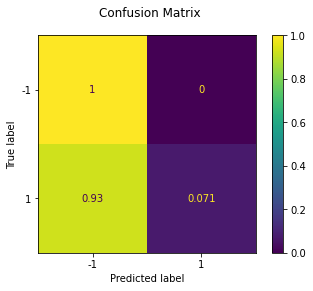

0.5455810716771051 0.5277777777777778
eta=0.1


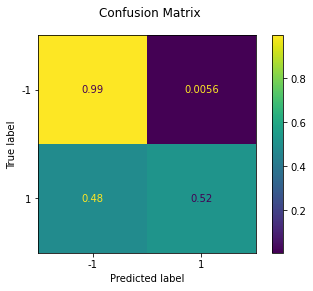

0.7731384829505915 0.7527777777777778
eta=0.01


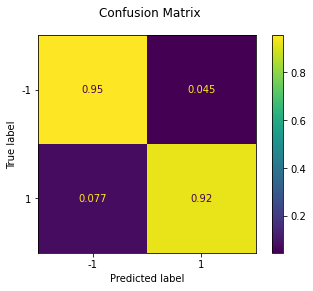

0.9109255393180237 0.9388888888888889
eta=0.001


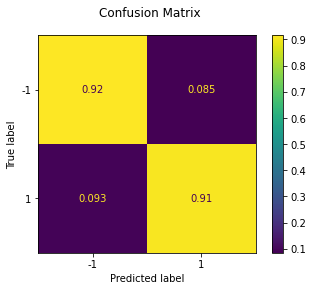

0.8844815588030619 0.9111111111111111
eta=0.0001


In [20]:
model = CustomLogisticRegression(eta=0.1)
fit_evaluate(model, X_train, y_train, X_test, y_test)
print("eta=0.1")
model = CustomLogisticRegression(eta=0.01)
fit_evaluate(model, X_train, y_train, X_test, y_test)
print("eta=0.01")
model = CustomLogisticRegression(eta=0.001)
fit_evaluate(model, X_train, y_train, X_test, y_test)
print("eta=0.001")
model = CustomLogisticRegression(eta=0.0001)
fit_evaluate(model, X_train, y_train, X_test, y_test)
print("eta=0.0001")

# Reducing the learning rate we can reach the point of global minimum of loss.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

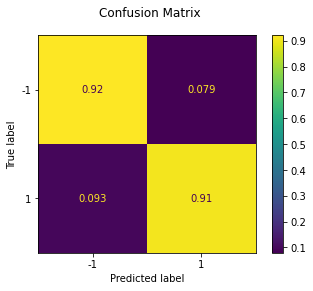

0.8879610299234516 0.9138888888888889
C = 0.1


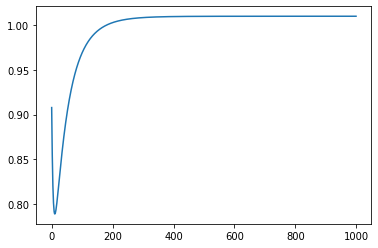

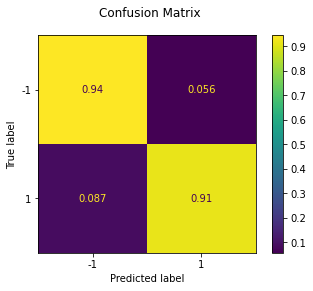

0.9039665970772442 0.9277777777777778
C = 0.5


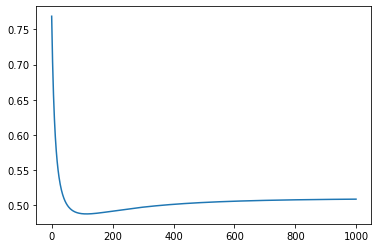

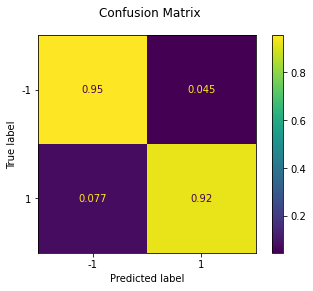

0.9109255393180237 0.9388888888888889
C = 1


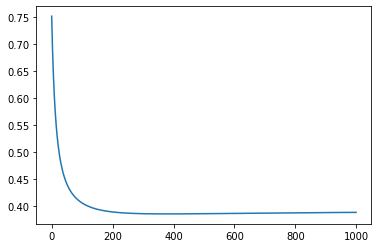

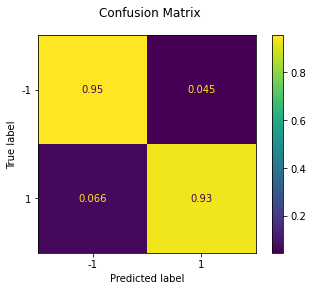

0.9137091162143354 0.9444444444444444
C = 10


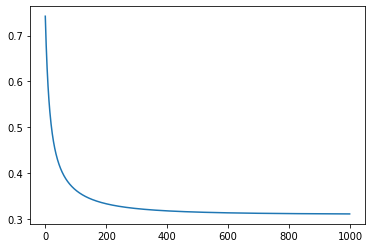

In [21]:
model = CustomLogisticRegression(C=0.1)
fit_evaluate(model, X_train, y_train, X_test, y_test)
plt.plot(model.loss_history)
print("C = 0.1")
model = CustomLogisticRegression(C=0.5)
fit_evaluate(model, X_train, y_train, X_test, y_test)
plt.plot(model.loss_history)
print("C = 0.5")
model = CustomLogisticRegression(C=1)
fit_evaluate(model, X_train, y_train, X_test, y_test)
plt.plot(model.loss_history)
print("C = 1")
model = CustomLogisticRegression(C=2)
fit_evaluate(model, X_train, y_train, X_test, y_test)
plt.plot(model.loss_history)
print("C = 10")

# Increasing regularization parameter value we reduce overfitting.

**(0.5 points)** Compare zero initialization and random initialization. 

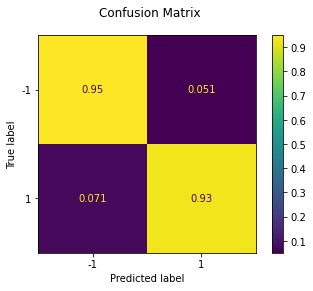

0.9116214335421016 0.9388888888888889
Zero initialization


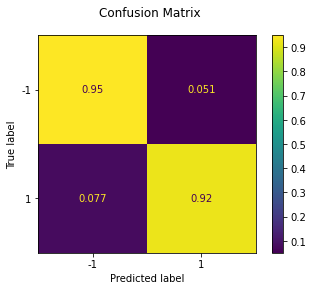

0.9116214335421016 0.9361111111111111
Random initialization - 1


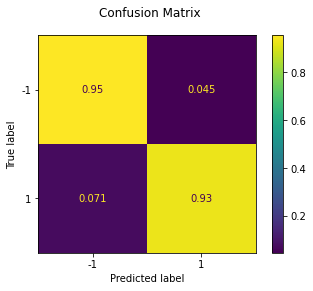

0.9123173277661796 0.9416666666666667
Random initialization - 5


In [22]:
model = CustomLogisticRegression(zero_init=True)
fit_evaluate(model, X_train, y_train, X_test, y_test)
print("Zero initialization")
model = CustomLogisticRegression(random_state=1)
fit_evaluate(model, X_train, y_train, X_test, y_test)
print("Random initialization - 1")
model = CustomLogisticRegression(random_state=5)
fit_evaluate(model, X_train, y_train, X_test, y_test)
print("Random initialization - 5")

# By trying various random initialization options, we can achieve a slight improvement in the result.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [23]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return np.sqrt(((np.expand_dims(X, 0) - np.expand_dims(Y, 1))**2).sum(axis=-1)).T
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        w = []
        for i in self.classes_:
            w.append(sum([weights[j] for j in range(len(y)) if y[j] == i]))
        return w
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            nearest_points = P.argsort(axis=1)[:, :self.n_neighbors]
            smallest_distances = P[np.arange(P.shape[0])[:,None], nearest_points]
            labels = self.y[nearest_points]
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / np.maximum(smallest_distances, self.eps)
            count_labels = np.array([self.get_class_weights(labels[i], weights_of_points[i]) for i in range(len(P))])
            weights_of_points = count_labels / np.expand_dims(count_labels.sum(axis=1), 1)     
            return weights_of_points
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return self.predict_proba(X).argmax(axis=1)

In [24]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [25]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [26]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

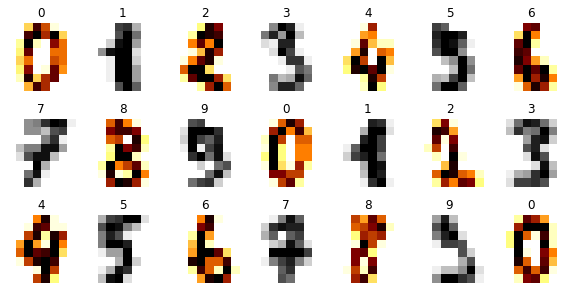

In [27]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [28]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [29]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

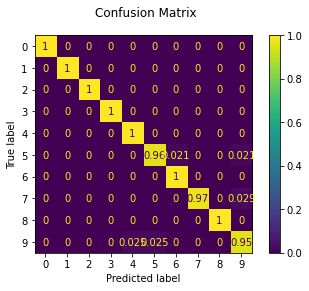

1.0 0.9861111111111112


In [30]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [31]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

# Number of the model confuses 4-9, 5-9, 6-5, 7-9. These numbers are similar.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

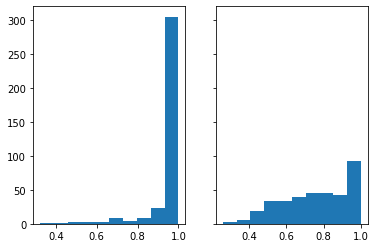

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

model = CustomKNeighborsClassifier(n_neighbors=10, weights='distance')
model.fit(X_train, y_train)
ax1.hist(model.predict_proba(X_test).max(axis=1));

model = CustomKNeighborsClassifier(n_neighbors=100, weights='distance')
model.fit(X_train, y_train)
ax2.hist(model.predict_proba(X_test).max(axis=1));

# By using a small and very large K value, the result is very noisy. We need to find the optimal value.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

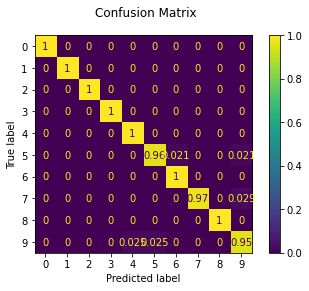

0.9895615866388309 0.9861111111111112


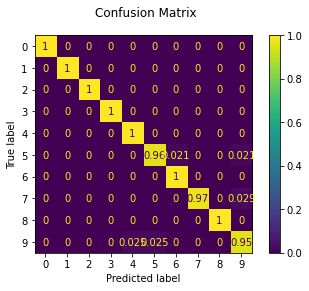

1.0 0.9861111111111112


(1.0, 0.9861111111111112)

In [33]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
fit_evaluate(model, X_train, y_train, X_test, y_test)
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
fit_evaluate(model, X_train, y_train, X_test, y_test)

# In this case we get same results. But if we will use "distance', we can get overfitted model.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

> Manhattan Distance – This distance is also known as taxicab distance or city block distance, that is because the way this distance is calculated. The distance between two points is the sum of the absolute differences of their Cartesian coordinates.

# This distance measurement function could improve the quality of the classification for this task. Because we are dealing with pixels.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

# The same task with discrete values.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [34]:
data = pd.read_csv('train.csv').set_index('PassengerId')

In [35]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [36]:
data['Sex'].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

In [37]:
data['Survived'].value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

In [38]:
pd.crosstab(data['Sex'], data['Survived'], normalize='index')

Survived,0,1
Sex,,
female,0.288475,0.711525
male,0.794205,0.205795


## Dataset contains 56114 men and 43886 women 
## Survived 42774 from 100000 people
## Women more often survived than men. 71% - women survived, 21% - men survived

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:xlabel='Age', ylabel='Count'>

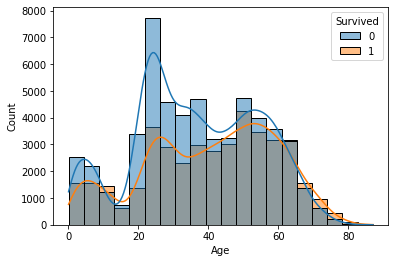

In [49]:
sns.histplot(data=data, x="Age", hue="Survived", kde=True, bins=20)

In [52]:
print("mean - \t", data['Age'].mean())
print("median - \t", data['Age'].median())

mean -  38.35547214294577
median -  39.0


In [53]:
print("mean of survived - \t", data[data['Survived'] == 1]['Age'].mean())
print("median of survived - \t", data[data['Survived'] == 1]['Age'].median())
print("mean of deceased - \t", data[data['Survived'] == 0]['Age'].mean())
print("median of deceased - \t", data[data['Survived'] == 0]['Age'].median())

mean of survived - 	 40.553799314307795
median of survived - 	 43.0
mean of deceased - 	 36.70869488153374
median of deceased - 	 36.0


# Looking at destribution we can see, young people(0-40 years) less survived.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Survived', ylabel='Pclass-Embarked'>

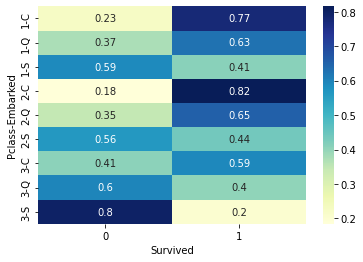

In [55]:
sns.heatmap(pd.crosstab([data['Pclass'], data['Embarked']], data['Survived'], 
            rownames=['Pclass', 'Embarked'], 
            normalize='index'), annot=True, center=0.5, cmap="YlGnBu")

## The **1st** class was the safest.
## **C** has highest survival rate.
### I can explain this by the cost of the ticket

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [59]:
data.isna().mean() * 100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

# We can fill missing values with median value of each feature or remove missing records. 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [69]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [70]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [71]:
def get_features(data):   
    X = data[['Pclass','Age','Sex','Fare','Embarked','SibSp','Parch']].copy()
    X['Sex'] = X['Sex'].map({'male':0,'female':1})
    X['Fare'] = X['Fare'].fillna(X['Fare'].median())
    X['Age'] = X['Age'].fillna(X['Age'].median())
    X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
    return X

In [72]:
def get_target(data):
    return data['Survived'].copy()

In [73]:
y_train = get_target(train_df)
X_train = get_features(train_df)
X_test = get_features(test_df)

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numeric_features = ['Age', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('encode', OneHotEncoder())
    ])

features_transformer = ColumnTransformer([
        ("num", num_pipeline, numeric_features),
        ("cat", cat_pipeline, categorical_features)
    ])

model = Pipeline([
    ('preprocessing',features_transformer),
    ('estimator', LogisticRegression())
])
display(model)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder())]),
                                                  ['Pclass', 'Sex', 'Embarked',
    

In [101]:
model.fit(X_train, y_train)
cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5).mean()

0.76691

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [103]:
save = pd.DataFrame()
save['PassengerId'] = test_df.PassengerId
save['Survived'] = model.predict(X_test)
save.to_csv('prediction.csv', index=False)

![kaggle score](kaggle_score.png)